In [45]:
!pip install plotly
!pip install opencage
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt
import scipy.spatial
from scipy.spatial import distance
from math import radians
import math

In [46]:
data=pd.read_csv('CityData_new.csv')

In [47]:
data

,CityName,Latitude,Longitude,Weight
0,Paris,48.866667,2.333333,6
1,Lyon,45.748457,4.846711,8
2,Marseille,43.285413,5.376060,5
3,Lille,50.632971,3.058585,9
4,Nice,43.713644,7.259520,10
...,...,...,...,...
281,Szeged,46.250000,20.166667,3
282,P?,46.075363,18.232845,4
283,Ny?gyh?,47.950000,21.716667,8
284,Sz?sfeh,47.687281,17.637616,5


In [48]:
lats=data['Latitude'].to_list()
lons=data['Longitude'].to_list()
#weights=data["Weight"].to_list()
Weights=data["Weight"].to_numpy()

In [49]:
import random
import numpy as np
import pandas as pd 
import scipy.spatial
from haversine import haversine
def distance(p1,p2):
  return haversine(p1[1:],p2[1:])

def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights = Weights[clusters==i],axis=0))
  return results

def kmeans(data, k=None, centroids=None, steps=30):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
  elbow = []
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: haversine(u,v))
    elbow.append(sqdists)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)

    if np.array_equal(new_centroids, centroids): 
      break
    centroids = new_centroids 
    
  return clusters, centroids,elbow

In [50]:
np_CityData = data[["Latitude","Longitude"]].to_numpy()
vals = data[['Latitude','Longitude']].values
sse=[]
for k in range(1,20):
    clusters,centroids,elbow=kmeans(vals,k)  
    for i in range(k):
        sqdist = np.sum(scipy.spatial.distance.cdist(np_CityData[clusters==i],centroids,'sqeuclidean'))
    sse.append(sqdist)
sse=sorted(sse,reverse=True)
sse
#solve 1d array 

[194582.82560446486,
 158707.15523326717,
 122539.47406976954,
 118063.16899261353,
 113169.63006873909,
 92266.55062548596,
 85273.6534007369,
 71013.91906871338,
 61252.33259482108,
 59104.169189429325,
 57509.29859420312,
 56438.13133711292,
 54037.22326921936,
 45303.492416700305,
 43241.39150013703,
 41471.28469190149,
 38519.92058131543,
 35395.348665123434,
 33826.46433194305]

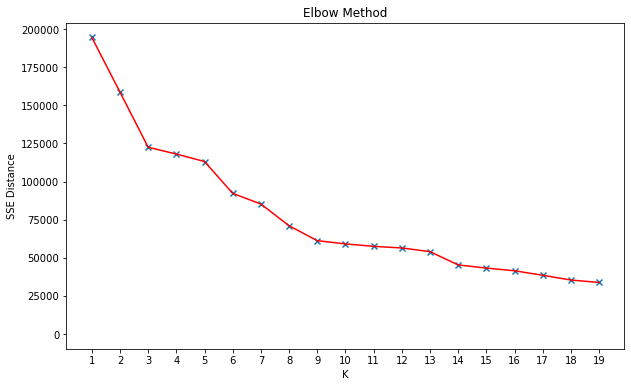

<Figure size 432x288 with 0 Axes>

In [51]:
fig = plt.figure(figsize=(10,6))
x=list(range(1,20))
labels=x
plt.plot(x,sse,'r')
plt.scatter(x,sse,marker='x')
plt.xticks(x, labels)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE Distance')
plt.plot([8, 8], [0,1.0417261149971132e+2 ],color='green',
         linestyle='dashed',linewidth=1)  # plotting the arbitrary line from point (25,10) to (65,45).    
plt.show()
plt.savefig('elbow.png')

In [52]:
#chose optimal no of cluster you want to have
k = 8
random.seed(42)
#run it
clusters,centroids,elbow=kmeans(vals,k)
centroids

[array([51.38011547,  7.23260675]),
 array([45.71201297,  8.40433378]),
 array([42.20139513, 18.19458595]),
 array([54.2884732 , 24.19001736]),
 array([48.11616857, 16.9254564 ]),
 array([47.49259463,  0.62073637]),
 array([39.99562777, -4.89352053]),
 array([46.54297481, 31.07046968])]

In [53]:
#using cDist see the distance between adjusted and old centroids
from scipy.spatial import distance
adjusted_centroids_cdist = [] 
distance_between_cdist_centroids = []
adjusted_centroids_haversine = [] 
distance_between_haversine_centroids = []

for i in range(len(centroids)):
    old_centroid = centroids[i]
    a = old_centroid
    #to use in haversine function we need to duplicate and add the same array with each other
    duplicated_double_array = np.stack((old_centroid, old_centroid))
    #city within that cluster
    cities_assigned_to_centroid = np_CityData[clusters==i]
    #closest city from our centroid usinf haversine
    closest_index_haversine = scipy.spatial.distance.cdist(duplicated_double_array, cities_assigned_to_centroid, lambda u, v: haversine(u,v)).argmin()
    #assingning that closest city as our new centroids
    new_centroid_haversine = cities_assigned_to_centroid[closest_index_haversine]
    #distance between those two
    distance_between_haversine_centroids.append(haversine(a,new_centroid_haversine))
    #adding that centroids to centroid array
    x = cities_assigned_to_centroid[closest_index_haversine]
    adjusted_centroids_haversine.append(x)
    
adjusted_centroids_haversine, distance_between_haversine_centroids



([array([51.270268,  7.167553]),
  array([45.783333,  9.083333]),
  array([42.286389, 18.84    ]),
  array([53.7559, 23.832 ]),
  array([48.15    , 17.116667]),
  array([47.394836,  0.703977]),
  array([40.412752, -3.707721]),
  array([46.463934, 30.738551])],
 [13.024097612349347,
  53.27967211806372,
  53.96219330216922,
  63.67009838370209,
  14.680280310664248,
  12.543907298573064,
  110.87082962872128,
  26.881346200454303])

In [54]:
#to see which is the new city which was assinged as adjusted centroids
'''for i in range(len(adjusted_centroids_haversine)):
    element = []
    element.append(adjusted_centroids_haversine[i][0])
    element.append(adjusted_centroids_haversine[i][1])
    mask = np.isin(np_CityData,element)
    a= np.nonzero(mask)
    print(a)
    print(data["CityName"][a[0]])'''

'for i in range(len(adjusted_centroids_haversine)):\n    element = []\n    element.append(adjusted_centroids_haversine[i][0])\n    element.append(adjusted_centroids_haversine[i][1])\n    mask = np.isin(np_CityData,element)\n    a= np.nonzero(mask)\n    print(a)\n    print(data["CityName"][a[0]])'

In [55]:
#we do not need that in anylogic
'''data['c']=[int(c) for c in clusters]
lats = [adjusted_centroids_haversine[i][0] for i in range(k)]
data['clat'] = data['c'].map(lambda x: lats[x])
longs = [adjusted_centroids_haversine[i][1] for i in range(k)]
data['clong'] = data['c'].map(lambda x: longs[x])

data'''

"data['c']=[int(c) for c in clusters]\nlats = [adjusted_centroids_haversine[i][0] for i in range(k)]\ndata['clat'] = data['c'].map(lambda x: lats[x])\nlongs = [adjusted_centroids_haversine[i][1] for i in range(k)]\ndata['clong'] = data['c'].map(lambda x: longs[x])\n\ndata"

In [56]:
m2 = folium.Map(
    location=[48.1351, 11.5820],
    zoom_start=4.4)
for row in data.iterrows():
    row=row[1]
    folium.CircleMarker(location=(row["Latitude"],
                                  row["Longitude"]),
                        radius= 2,
                        color="#007849",
                       # popup=row['Facility_Name'],
                        fill=False).add_to(m2)
for i in range(len(adjusted_centroids_haversine)):
    folium.CircleMarker(location=(adjusted_centroids_haversine[i][0],
                                  adjusted_centroids_haversine[i][1]),
                        radius= 2,
                        color="black",
                       # popup=row['Facility_Name'],
                        fill=False).add_to(m2)
    
    
for i in range(len(centroids)):
    folium.CircleMarker(location=(centroids[i][0],
                                  centroids[i][1]),
                        radius= 2,
                        color="red",
                       # popup=row['Facility_Name'],
                        fill=False).add_to(m2)
#folium.LayerControl().add_to(m2)
m2